<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/barcodeZXing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Instala el binding de ZXing-C++ (solo la primera vez). OpenCV ya viene en Colab.
!pip install -q zxing-cpp


Saving IMG_8938.png to IMG_8938 (1).png


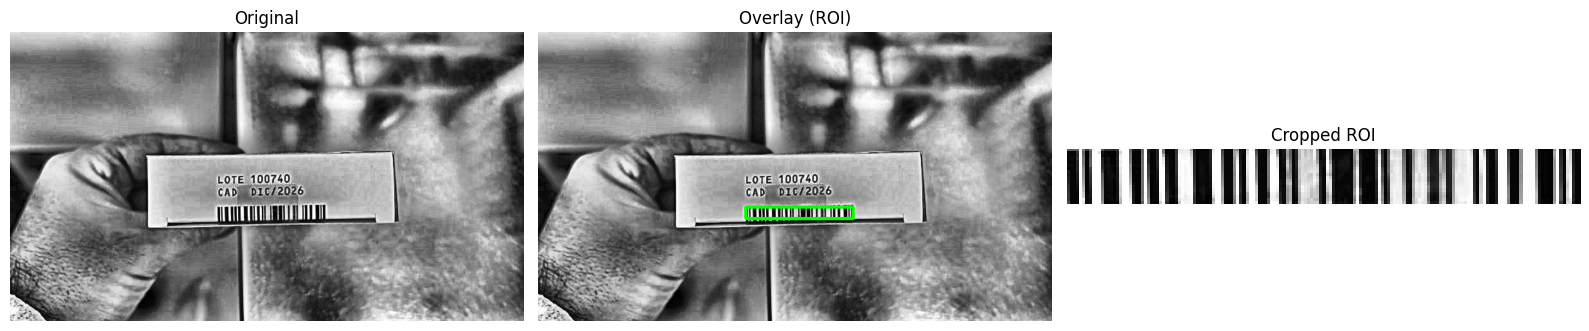

—— ZXing result ——
Decoded value : '302876C'
Symbology     : Code128
Barcode box   : [x=323, y=272, w=167, h=18]


In [5]:
# Barcode ROI quick demo

import io
import numpy as np
import cv2
import zxingcpp
import matplotlib.pyplot as plt
from google.colab import files

# ========= Helpers =========
def np_from_image_bytes(img_bytes: bytes) -> np.ndarray:
    """Decode bytes -> BGR np.ndarray (siempre 3 canales)."""
    arr = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)  # BGR
    return img

def bbox_from_corners(corners):
    """
    corners: iterable de 4 puntos con attrs .x, .y.
    Devuelve bbox [x, y, w, h] (enteros) con origen top-left.
    """
    xs = [int(round(p.x)) for p in corners]
    ys = [int(round(p.y)) for p in corners]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    return [x1, y1, max(1, x2 - x1), max(1, y2 - y1)]

def clamp_bbox_to_image(bbox, width, height):
    """Asegura que la bbox queda dentro de la imagen."""
    x, y, w, h = bbox
    x = max(0, min(int(x), width - 1))
    y = max(0, min(int(y), height - 1))
    w = max(1, min(int(w), width - x))
    h = max(1, min(int(h), height - y))
    return [x, y, w, h]

def ensure_u8_contiguous(gray: np.ndarray) -> np.ndarray:
    """Convierte a uint8 C-contiguous, como prefiere ZXing para 1D."""
    if gray.dtype != np.uint8:
        gray = gray.astype(np.uint8)
    if not gray.flags["C_CONTIGUOUS"]:
        gray = np.ascontiguousarray(gray)
    return gray

def bgr_to_rgb(img_bgr: np.ndarray) -> np.ndarray:
    """Para mostrar con matplotlib (espera RGB)."""
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# ========= Workflow =========
# 1) Seleccionar imagen desde tu equipo
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")

name, content = next(iter(uploaded.items()))
img_bgr = np_from_image_bytes(content)
if img_bgr is None:
    raise SystemExit("Failed to decode image.")

# 2) Preparar imagen para ZXing (grayscale, uint8, contiguous)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
gray = ensure_u8_contiguous(gray)

# 3) Leer códigos con ZXing
results = zxingcpp.read_barcodes(gray)

decoded_value = None
symbology = None
overlay_bgr = img_bgr.copy()
roi_bgr = None
bbox = None

if results:
    # Tomamos el primero para simplicidad
    r = results[0]
    decoded_value = getattr(r, "text", None)
    symbology = r.format.name if getattr(r, "format", None) else None

    pos = getattr(r, "position", None)
    if pos is not None:
        corners = [pos.top_left, pos.top_right, pos.bottom_right, pos.bottom_left]
        bbox = bbox_from_corners(corners)
    else:
        # Respaldo: toda la imagen
        h, w = gray.shape[:2]
        bbox = [0, 0, w, h]

    # Clamp y recorte
    H, W = gray.shape[:2]
    x, y, bw, bh = clamp_bbox_to_image(bbox, W, H)
    # Dibujar ROI
    cv2.rectangle(overlay_bgr, (x, y), (x + bw, y + bh), (0, 255, 0), thickness=3)
    roi_bgr = img_bgr[y:y+bh, x:x+bw]
else:
    # Sin detección: dibujamos nada y avisamos
    pass

# 4) Mostrar resultados
fig = plt.figure(figsize=(16, 5))

# Original
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(bgr_to_rgb(img_bgr))
ax1.set_title("Original")
ax1.axis("off")

# Overlay con ROI
ax2 = plt.subplot(1, 3, 2)
title2 = "Overlay (no barcode found)" if bbox is None else "Overlay (ROI)"
ax2.imshow(bgr_to_rgb(overlay_bgr))
ax2.set_title(title2)
ax2.axis("off")

# ROI recortada (si hay)
ax3 = plt.subplot(1, 3, 3)
if roi_bgr is not None:
    ax3.imshow(bgr_to_rgb(roi_bgr))
    ax3.set_title("Cropped ROI")
else:
    # Mostrar un placeholder simple si no hubo ROI
    placeholder = np.full((200, 400, 3), 230, dtype=np.uint8)
    cv2.putText(placeholder, "No barcode ROI", (20, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (50, 50, 50), 2, cv2.LINE_AA)
    ax3.imshow(bgr_to_rgb(placeholder))
    ax3.set_title("Cropped ROI")
ax3.axis("off")

plt.tight_layout()
plt.show()

# 5) Imprimir datos leídos (si hay)
print("—— ZXing result ——")
if results:
    print(f"Decoded value : {decoded_value!r}")
    print(f"Symbology     : {symbology}")
    if bbox:
        x, y, w, h = bbox
        print(f"Barcode box   : [x={x}, y={y}, w={w}, h={h}]")
else:
    print("No barcode detected.")
